In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
import gensim
# import textblob
import spacy

## **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Doc2Vec
- Begin modelling
    - Algorithms to use;
        - k-Nearest Neighbors.
        - Decision Trees.
        - Naive Bayes.
        - Random Forest.
        - Gradient Boosting.
        - Logistic Regression
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [2]:
df_clean = pd.read_csv('../../../../cleaned_reviews.csv')

In [3]:
df_clean.shape

(17340, 4)

In [4]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [5]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [6]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [7]:
df_clean.dropna(inplace=True)

In [8]:
df_clean.shape

(17337, 2)

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [10]:
# print(my_stop_words)

In [11]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [14]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [15]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [16]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

Sentiment Mapping

In [17]:
sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [18]:
df_clean.drop(columns=['sentiments'],inplace=True)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,cross_val_score

# The algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

**Two versions of Doc2Vec**
- PV-DM (Paragragh Vector Distributed Memory)
- PV-DBOW (Paragragh Vector Distributed Bag of Words)

**The effect of window**

For example "stackoverflow great website for programmers" with 5 words (suppose we save the stop words great and for here) if the window size is 2 then the vector of word "stackoverflow" is directly affected by the word "great" and "website", if the window size is 5 "stackoverflow" can be directly affected by two more words "for" and "programmers". The 'affected' here means it will pull the vector of two words closer.

So it depends on the material you are using for training, if the window size of 2 can capture the context of a word, but 5 is chosen, it will decrease the quality of the learnt model, and vise versa.

**Are tags needed?**

https://stackoverflow.com/questions/73254708what-is-the-purpose-of-tags-in-doc2vec-taggeddocument

The 'tag' is just the key with which to look-up the learned document vector, after training is done.

The original 'Paragraph Vectors' research papers, on which Gensim's Doc2Vec is based, tended to just assume each document had one unique ID – perhaps, a string token just like any other word. (So, too, did a small patch to the original Google word2vec.c that was once shared, long ago, as a limited example of one mode of 'paragraph vectors`.)

In those original formulations, documents had just one unique ID – lookup key for their vector.

However, it was a fairly obvious/straightforward extension to allow these associated vectors to potentially map to other known shared labels, across many documents. (That is, not a unique vector per document, but a unique vector per label, which might appear on multiple texts.) And further, that multiple such range-of-text vectors might be relevant to a single text, that's known to deserve more-than-one label.

So the word 'tag' was used in the Gensim implementation, to convery that this is an association more general than either a unique-ID, or a known-label, though it might in some cases be either.

If you're just starting out, or trying to match early papers, just consider the 'tag' a single unique ID per document. Give every independent document its own unique name – whether it's something natural from your data source (like a unique article title or primary key), or a mere serial number, from '0' to the count of docs in your data.

Only if you're trying expert/experimental other approaches, after understanding the basic approach, would you want to either repeat a 'tag' across multiple documents, or use mroe than one 'tag' per document. Neither to those approaches are necessary, or typical, in the initial application of Doc2Vec.

**(And if you start to re-use known tags in training, Doc2Vec is no longer a strictly 'unsupervised' machine-learning technique, but starts to behave more like a 'supervised' or 'semi-supervised' technique, where you're nudging the algorithm towards desired answers. That's sometimes useful, and appropriate, but starts to complicate estimates of how well your steps are working: you then have to use things like held-back test/validation data to get trustworthy estimates of your system's success.)**

For this project, the tagged approach shall be adopted for the modelling.

In [20]:
df_clean.columns

Index(['tokens', 'sentiment_label'], dtype='object')

In [21]:
train, test = train_test_split(df_clean,test_size=.2,random_state=42, 
                                            stratify=df_clean.sentiment_label)

In [22]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [23]:
# Tagging the train ad test set

# Tag train set 
tagged_train = train.apply(
    lambda x: TaggedDocument(words=x["tokens"],tags=[x.sentiment_label]),
    axis=1
)

# Tag test set 
tagged_test = test.apply(
    lambda x: TaggedDocument(words=x["tokens"],tags=[x.sentiment_label]),
    axis=1
)

In [24]:
# looking into the tags
tagged_train.values[0]

TaggedDocument(words=['pair', 'headphone', 'work', 'plan', 'buy', 'pair', 'current', 'pair', 'gotten', 'damage', 'put', 'pair', 'uneven', 'surface', 'wire', 'tug', 'too', 'knock', 'head', 'phone', 'accident', 'time', 'walk', 'wear', 'head', 'phone', 'drop', 'phone', 'cord', 'got', 'accidentally', 'tug', 'unplugged', 'phone', 'won', 'headphone', 'outside', 'room', 'anymore', 'room', 'organize', 'shouldn', 'end', 'knock', 'accident', 'anymore'], tags=[-1])

In [25]:
tagged_test.values[0]

TaggedDocument(words=['break', 'right', 'run', 'return', 'window', 'came', 'narrow', 'move', 'link', 'event', 'not', 'don', 'know', 'problem'], tags=[-1])

### **Setting up DOC2VEC**

As previously mentioned there are two versions of Doc2Vec namely;
- PV-DM (Paragragh Vector Distributed Memory)
- PV-DBOW (Paragragh Vector Distributed Bag of Words)

**When dm=0, it signifies PV-DBOW. But if dm=1, it signifies PV-DM**

The default mode is `dm=1, dm_mean=None, dm_concat=0` - which means the PV-DM mode from the 'Paragraph Vector' paper, with no local preference on mean-vs-sum (thus the superclass Word2Vec `cbow_mean=1` is used, meaning 'mean'), and no concatenation. 

In [26]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores # Mine is 8 cores
four_cores = cores-4
four_cores

4

### **Building the Vocabulary**

In [27]:
# dm=1, it signifies PV-DM
model_dm = Doc2Vec(
    dm=1,
    vector_size=25,
    min_count=2,
    sample=0,
    workers=four_cores,
    hs=0,
    seed= 42,
    negative=5
)

In [28]:
model_dm.build_vocab(tagged_train)

In [29]:
model_dm.wv.index_to_key[:10]

['work',
 'mouse',
 'not',
 'great',
 'charge',
 'use',
 'sound',
 'good',
 'love',
 'buy']

In [30]:
# Word Apperance Count
def word_count(word:str):
    print(f"Word {word} appeared {model_dm.wv.get_vecattr(word, 'count')} times in the training corpus.")


word_count("terrible")

Word terrible appeared 130 times in the training corpus.


In [31]:
# Next, train the model on the corpus.
# Setting alpha
# model_dm.alpha=0.025
model_dm.alpha=0.01
model_dm.train(
                tagged_train,
                total_examples=model_dm.corpus_count,
                epochs=100,
)

In [32]:
# checking the alpha value
model_dm.alpha

0.01

In [33]:
# vector = model_dm.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
# print(vector)
# when alpha = 0.025
# [ 0.03088093 -0.5032935   0.8709761  -0.14471954 -0.51347566 -0.0413893
#  -0.97517926 -0.55330914  0.17404126 -0.08058983 -0.07980805 -0.17554903
#   0.42250898  0.11531922 -0.16197139  0.21262398  0.53194374  0.8020486
#   0.0788317  -0.07520911  0.06067129 -0.22822483  1.879647   -0.5095055
#  -0.23471344]

# when alpha = 0.01
# [ 0.04682843 -0.2397281   0.3805967  -0.05684782 -0.36029288 -0.09569938
#  -0.47186413 -0.21873721 -0.02397618 -0.07472132 -0.17192663 -0.18020546
#   0.16713257  0.09434006 -0.03241999  0.0368213   0.20066081  0.41485688
#   0.01419257 -0.01322524 -0.0148872   0.04713954  0.7573208  -0.3150059
#  -0.16141124]

In [34]:
# Saving the model
# model_dm.save("pv_dm_25.model")

In [37]:
range(len(tagged_train))

range(0, 13869)

In [38]:
range(len(tagged_test))

range(0, 3468)

In [45]:
# https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    y, X = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=100)) for doc in sents])
    return X,y

In [46]:
X_train, y_train = vec_for_learning(model_dm, tagged_train)
X_test, y_test = vec_for_learning(model_dm, tagged_test)

In [55]:
print(X_train[:2])
print(y_train[:2])

(array([ 1.1725981 ,  0.8064803 , -0.31392628, -0.29607132,  0.21388273,
        0.10011885,  0.2179238 ,  0.13950612, -0.20796932, -0.32925504,
       -0.7957169 , -0.02953051, -1.3746154 ,  0.69912523,  0.707025  ,
       -0.05619648, -0.43548617, -1.2366815 , -2.39172   ,  0.46708214,
       -2.498184  ,  0.03706764,  0.493668  ,  0.3823246 , -0.0201479 ],
      dtype=float32), array([-1.1787281 ,  1.3613862 , -1.1451803 , -0.55830616, -1.8505179 ,
       -0.5871689 , -0.54500437, -0.27827114, -0.6749351 , -0.24336602,
       -0.9167783 , -0.3193957 , -0.303847  ,  0.1630032 ,  1.1275488 ,
        0.70167947, -0.9690223 ,  0.9580181 ,  0.14358841,  1.0604248 ,
       -0.10667342,  1.5147026 , -1.9163258 , -1.4297863 ,  0.12263586],
      dtype=float32))
(-1, 1)


In [49]:
models = {
    "DT": DecisionTreeClassifier(max_depth=3,random_state=42),
    "RF": RandomForestClassifier(max_depth=3,random_state=42),
    "GB": GradientBoostingClassifier(max_depth=3,random_state=42),
    "KNN": KNeighborsClassifier(),
    "MNB": MultinomialNB(),
    "LR": LogisticRegression(multi_class='multinomial',solver='lbfgs'),
    "HGB": HistGradientBoostingClassifier(max_depth=3,random_state=42)
}

In [48]:
model_results_f1_macro = []
model_names = []
model_mean = []

In [56]:
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42) # 10% for validation 
scoring = 'f1_macro'
for name, model in models.items():
    model_names.append(name) # append each name of the model
    print(model) # print the model name for checks
    cv_results = cross_val_score(model,X_train,y_train,scoring=scoring,cv=my_cv,n_jobs=-2) 
    cv_results_list = cv_results.tolist() # Turning the array to a list
    model_results_f1_macro.append(cv_results_list) # append validation results
    model_mean.append(cv_results.mean()) # append the mean

DecisionTreeClassifier(max_depth=3, random_state=42)
RandomForestClassifier(max_depth=3, random_state=42)
GradientBoostingClassifier(random_state=42)
KNeighborsClassifier()
MultinomialNB()
LogisticRegression(multi_class='multinomial')
HistGradientBoostingClassifier(max_depth=3, random_state=42)


In [57]:
print(model_results_f1_macro)
print(model_names)
print(model_mean)

[[0.3995857824534152, 0.3984174484022323, 0.39333893871449926, 0.4166005214647193, 0.4033353587566408], [0.3499830932575912, 0.36261222938098897, 0.36106075029862783, 0.3548602150537634, 0.36956803649457326], [0.6288651897858336, 0.6108650794066541, 0.6192378973387243, 0.593732200746948, 0.5947301170622157], [0.5613447745664916, 0.5339884021723883, 0.5450850727387729, 0.5698200319850454, 0.5379922932746597], [nan, nan, nan, nan, nan], [0.66174329977869, 0.6627323932842791, 0.6579738506030718, 0.6732515800772768, 0.6486510536282024], [0.6613430566918939, 0.6245666902238395, 0.6497063448598045, 0.6412610338377969, 0.625443245231494]]
['DT', 'RF', 'GB', 'KNN', 'MNB', 'LR', 'HGB']
[0.40225560995830134, 0.3596168648971089, 0.6094860968680751, 0.5496461149474715, nan, 0.660870435474304, 0.6404640741689657]


In [58]:
# Creating a Dictionary of results
f1score_result_dict = dict(zip(model_names,model_results_f1_macro))
f1score_mean_dict = dict(zip(model_names,model_mean))

In [59]:
# Creating a Dataframe of results
f1score_result_frame = pd.DataFrame(f1score_result_dict)
f1score_mean_frame = pd.Series(f1score_mean_dict).to_frame('mean_f1_score').reset_index()
f1score_mean_frame.rename(columns={'index':'models'},inplace=True)

In [60]:
f1score_result_frame

,DT,RF,GB,KNN,MNB,LR,HGB
0,0.399586,0.349983,0.628865,0.561345,NaN,0.661743,0.661343
1,0.398417,0.362612,0.610865,0.533988,NaN,0.662732,0.624567
2,0.393339,0.361061,0.619238,0.545085,NaN,0.657974,0.649706
3,0.416601,0.354860,0.593732,0.569820,NaN,0.673252,0.641261
4,0.403335,0.369568,0.594730,0.537992,NaN,0.648651,0.625443


In [61]:
f1score_result_frame.to_csv("validation_doc2vec_25/doc2vec_25_f1score_results.csv",index=False)

In [62]:
f1score_mean_frame.sort_values(by='mean_f1_score',ascending=False)

,models,mean_f1_score
5,LR,0.660870
6,HGB,0.640464
2,GB,0.609486
3,KNN,0.549646
0,DT,0.402256
1,RF,0.359617
4,MNB,NaN


In [63]:
f1score_mean_frame.to_csv("validation_doc2vec_25/doc2vec_25_f1score_mean_results.csv")

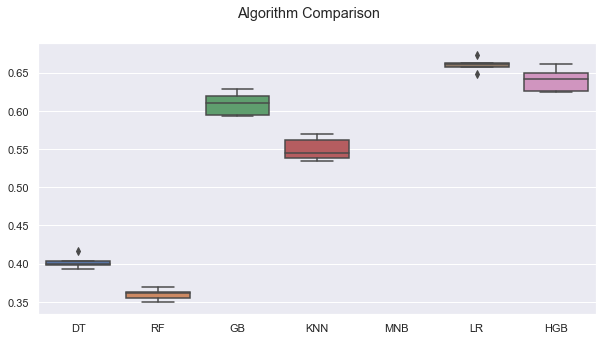

In [64]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=f1score_result_frame)
ax.set_xticklabels(model_names)
fig.suptitle('Algorithm Comparison')
plt.show()

Based off the plot above, the top three algorithms are;
1. Logistic regression
2. HistGradientBoostingClassifier
3. GradientBoostingClassifier

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
# Without PCA
pipe = Pipeline([('clf',LogisticRegression(multi_class='multinomial',
                                            solver='lbfgs'))])

In [68]:
paramter_grid = {'clf__C':[0.0001,0.001,0.1,1,10,100]
                }
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42)

In [69]:
mygrid = GridSearchCV(pipe,param_grid=paramter_grid,cv=my_cv,scoring='f1_macro')
mygrid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'clf__C': [0.0001, 0.001, 0.1, 1, 10, 100]},
             scoring='f1_macro')

In [70]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf__C': 10}

Best estimator: Pipeline(steps=[('clf', LogisticRegression(C=10, multi_class='multinomial'))])

Best validation score: 0.6646806589412358


In [83]:
mygrid_trainset = mygrid.best_estimator_
mygrid_trainset

# Pipeline(steps=[('clf', LogisticRegression(C=10, multi_class='multinomial'))])
# Best validation score: 0.6646806589412358

Pipeline(steps=[('clf', LogisticRegression(C=10, multi_class='multinomial'))])

              precision    recall  f1-score   support

          -1       0.69      0.26      0.38      1227
           0       0.69      0.80      0.74      5040
           1       0.87      0.86      0.86      7602

    accuracy                           0.79     13869
   macro avg       0.75      0.64      0.66     13869
weighted avg       0.79      0.79      0.78     13869



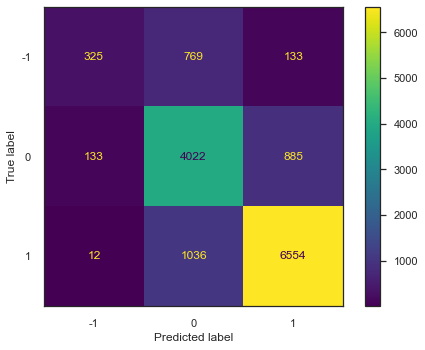

In [84]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = mygrid_trainset.predict(X_train)



y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    disp.figure_.savefig('model_doc2vec_25_img/confusion_matrix_no_PCA_df_clean.png',dpi=300)


class_report(mygrid_trainset,y_train,y_pred_train)

**ROC on training data**

In [85]:
lgr = LogisticRegression(C=10, multi_class='multinomial',solver="lbfgs")

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

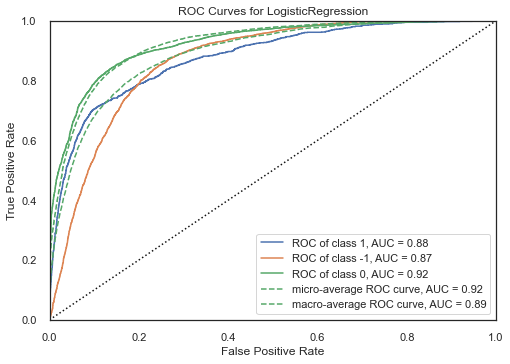

In [86]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(lgr, classes=[-1,0,1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_train, y_train)        # Evaluate the model on the training data
visualizer.show(outpath="model_doc2vec_25_img/roc_without_PCA_df_clean.png")
# Without PCA: AUC score using OvR, macro-averaged over all classes: 0.89

AUC macro is quite good but the f1-score macro tells a different story, especially the confusion matrix

**Building the model with best estimator and testing on test data**

In [92]:
lgr = LogisticRegression(C=10, multi_class='multinomial',solver="lbfgs")

lgr.fit(X_train,y_train)

LogisticRegression(C=10, multi_class='multinomial')

              precision    recall  f1-score   support

          -1       0.52      0.24      0.33       307
           0       0.65      0.74      0.69      1260
           1       0.83      0.82      0.83      1901

    accuracy                           0.74      3468
   macro avg       0.67      0.60      0.62      3468
weighted avg       0.74      0.74      0.73      3468



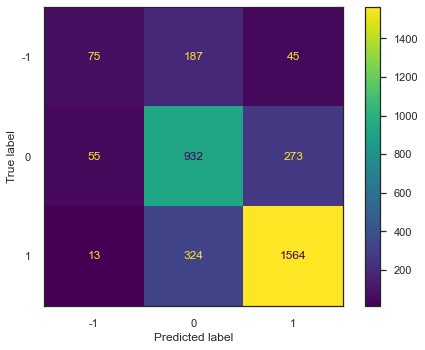

In [93]:
# Classification report test data
y_test = y_test
y_pred_test = lgr.predict(X_test)
sns.set_theme(style='white')
def class_report(model,y_test,pred):
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test,pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    disp.figure_.savefig('model_doc2vec_25_img/confusion_matrix_test_data_no_PCA_df_clean.png',dpi=300)


class_report(lgr,y_test,y_pred_test)

**ROC on test data**

In [94]:
lgr = LogisticRegression(C=10, multi_class='multinomial',solver="lbfgs")

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

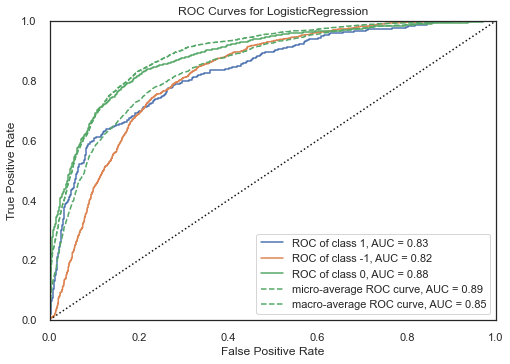

In [95]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(lgr, classes=[-1,0,1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)          # Evaluate the model on the training data
visualizer.show(outpath="model_doc2vec_25_img/roc_test_data_without_PCA_df_clean.png")
# Without PCA: AUC score using OvR, macro-averaged over all classes: 0.85

## **Conclusion**

- Using Doc2Vec-25 dimension size(PV-DM), it trained quite fast but there was a poor performance; maybe due the alpha or could it be the vector size?


**Table of Values**

dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean_(train data)|0.66|0.89
df_clean (test data)|0.62|0.85